In [1]:
import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
from gpytorch.distributions import MultivariateNormal

# ===============================================================
# GLOBALS
# ===============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
torch.set_default_dtype(dtype)

In [3]:
# ===============================================================
# 0. SYNTHETIC 2D "MODIS-LIKE" GEOSPATIAL FIELD
# ===============================================================

def f_true_2d(lat_norm, lon_norm):
    """
    Synthetic non-stationary geospatial field on [0,1]x[0,1].
    lat_norm ~ normalized latitude
    lon_norm ~ normalized longitude
    """
    x = lat_norm
    y = lon_norm

    f = np.zeros_like(x)

    # Region A: south-west, smooth low frequency
    region_a = (x < 0.4) & (y < 0.5)
    f[region_a] = (
        8 * np.sin(2 * np.pi * x[region_a])
        + 4 * np.cos(2 * np.pi * y[region_a])
    )

    # Region B: central band, higher frequency in x
    region_b = (x >= 0.4) & (x < 0.8)
    f[region_b] = (
        5 * np.sin(6 * np.pi * x[region_b])
        + 6 * np.sin(4 * np.pi * y[region_b] + 0.5)
    )

    # Region C: north or far east, different frequency mix
    region_c = (x >= 0.8) | (y >= 0.8)
    f[region_c] = (
        10 * np.sin(3 * np.pi * x[region_c] + np.pi / 4)
        + 3 * np.cos(8 * np.pi * y[region_c])
    )

    # Strong local anomaly (hotspot) to make things nasty
    f += 7 * np.exp(-120 * ((x - 0.75)**2 + (y - 0.25)**2))

    # Another smaller anomaly
    f += 4 * np.exp(-180 * ((x - 0.25)**2 + (y - 0.8)**2))

    return f

def heteroscedastic_noise_2d(lat_norm, lon_norm):
    x = lat_norm
    y = lon_norm
    noise = (
        0.05
        + 0.4 * x
        + 0.3 * y**2
        + 0.3 * np.sin(3 * np.pi * x * y)
    )
    return np.clip(noise, 0.05, 1.0)


def generate_geospatial_data(
    n_lat=35, n_lon=45, n_train=600, seed=0
):
    """
    Generate 2D grid, then subsample n_train points for training.
    """
    rng = np.random.default_rng(seed)

    lat = np.linspace(25, 60, n_lat)
    lon = np.linspace(-130, -65, n_lon)
    LAT, LON = np.meshgrid(lat, lon, indexing="ij")

    # Normalized coords in [0,1]
    lat_norm = (LAT - LAT.min()) / (LAT.max() - LAT.min())
    lon_norm = (LON - LON.min()) / (LON.max() - LON.min())

    f_clean = f_true_2d(lat_norm, lon_norm)
    noise_std = heteroscedastic_noise_2d(lat_norm, lon_norm)
    y_noisy = f_clean + noise_std * rng.normal(size=f_clean.shape)

    # Flatten
    X_full = np.column_stack(
        [lat_norm.ravel(), lon_norm.ravel()]
    )
    y_full = y_noisy.ravel()
    f_full = f_clean.ravel()

    # Subsample training points
    N_full = X_full.shape[0]
    idx = rng.choice(N_full, size=min(n_train, N_full), replace=False)
    X_train_np = X_full[idx]
    y_train_np = y_full[idx]

    X_train = torch.tensor(X_train_np, dtype=dtype, device=device)
    y_train = torch.tensor(y_train_np, dtype=dtype, device=device)

    print(f"Full grid: {n_lat} x {n_lon} = {N_full} points")
    print(f"Training subsample: {X_train.shape[0]} points")

    return (
        lat_norm,
        lon_norm,
        f_clean,
        X_full,
        f_full,
        X_train_np,
        y_train_np,
        X_train,
        y_train,
    )

In [4]:
# ===============================================================
# 1. LATENT 1D NNs FOR GSM PER DIMENSION
# ===============================================================

class LatentNN1D(nn.Module):
    """
    1D latent: s -> w_i(s), mu_i(s), ell_i(s) for i=1..Q
    """

    def __init__(self, hidden_dim=32, Q=5):
        super().__init__()
        self.Q = Q
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3 * Q),
        )

    def forward(self, s):
        """
        s: (N,1)
        returns w, mu, ell each (N,Q)
        """
        h = self.net(s)             # (N,3Q)
        h = h.view(-1, 3, self.Q)   # (N,3,Q)
        raw_w = h[:, 0, :]
        raw_mu = h[:, 1, :]
        raw_ell = h[:, 2, :]

        # Ranges inspired by paper (freq up to Nyquist-like, etc.)
        w = 0.1 + 2.9 * torch.sigmoid(raw_w)
        mu = 0.2 + 5.8 * torch.sigmoid(raw_mu)
        ell = 0.05 + 0.65 * torch.sigmoid(raw_ell)
        return w, mu, ell

In [5]:
# ===============================================================
# 2. GSM KERNEL 1D (EQ. 7)
# ===============================================================

def gsm_1d_kernel(s1, s2, latent_nn, Q):
    """
    1D GSM kernel between scalar coords s1,s2:
      k(x,x') = sum_i w_i(x)w_i(x') k_gibbs,i(x,x') cos(2π(μ_i(x)x - μ_i(x')x'))
    s1: (N,1)
    s2: (M,1)
    """
    N = s1.shape[0]
    M = s2.shape[0]

    w1, mu1, ell1 = latent_nn(s1)  # (N,Q)
    w2, mu2, ell2 = latent_nn(s2)  # (M,Q)

    s1_exp = s1.view(N, 1)
    s2_exp = s2.view(1, M)
    diff2 = (s1_exp - s2_exp) ** 2  # (N,M)

    K = torch.zeros(N, M, dtype=dtype, device=device)

    for q in range(Q):
        w1_q = w1[:, q]           # (N,)
        w2_q = w2[:, q]           # (M,)
        mu1_q = mu1[:, q]
        mu2_q = mu2[:, q]
        ell1_q = ell1[:, q]
        ell2_q = ell2[:, q]

        w_prod = w1_q.view(N, 1) * w2_q.view(1, M)

        ell1_sq = ell1_q.view(N, 1) ** 2
        ell2_sq = ell2_q.view(1, M) ** 2
        ell_sum = ell1_sq + ell2_sq + 1e-6

        # Gibbs kernel
        gibbs_pref = torch.sqrt(
            2.0 * ell1_q.view(N, 1) * ell2_q.view(1, M) / ell_sum
        )
        gibbs_exp = torch.exp(-diff2 / ell_sum)
        k_gibbs = gibbs_pref * gibbs_exp

        # Cosine term
        phase1 = 2 * np.pi * (mu1_q.view(N, 1) * s1_exp)
        phase2 = 2 * np.pi * (mu2_q.view(1, M) * s2_exp)
        cos_term = torch.cos(phase1 - phase2)

        K = K + w_prod * k_gibbs * cos_term

    return K

In [6]:
# ===============================================================
# 3. FULL 2D GSM KERNEL (PRODUCT OVER DIMENSIONS, EQ. 8)
# ===============================================================

class GSMKernel2D(gpytorch.kernels.Kernel):
    """
    2D GSM kernel using Eq. (8): product of 1D GSM per dimension.
      k(x,x') = Π_p k_GSM^p(x_p, x'_p)
    """

    is_stationary = False

    def __init__(self, Q=5, hidden_dim=32):
        super().__init__()
        self.Q = Q
        # independent latent GPs per dimension, parameterized by NNs
        self.latent_lat = LatentNN1D(hidden_dim=hidden_dim, Q=Q)
        self.latent_lon = LatentNN1D(hidden_dim=hidden_dim, Q=Q)

    def forward(self, x1, x2, diag=False, **params):
        x1 = x1.view(-1, 2)
        x2 = x2.view(-1, 2)
        N, M = x1.shape[0], x2.shape[0]

        lat1 = x1[:, 0:1]
        lon1 = x1[:, 1:1+1]
        lat2 = x2[:, 0:1]
        lon2 = x2[:, 1:1+1]

        K_lat = gsm_1d_kernel(lat1, lat2, self.latent_lat, self.Q)
        K_lon = gsm_1d_kernel(lon1, lon2, self.latent_lon, self.Q)

        K = K_lat * K_lon

        if diag:
            return K.diag()

        if N == M:
            K = K + 1e-5 * torch.eye(N, device=device)

        return K

In [7]:
# ===============================================================
# 4. 1D STATIONARY SM KERNEL + 2D PRODUCT SM (EQ. 8)
# ===============================================================

class SMKernel1D(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, Q=5):
        super().__init__()
        self.Q = Q
        self.log_w = nn.Parameter(torch.randn(Q) * 0.1)
        self.log_mu = nn.Parameter(torch.randn(Q) - 0.5)
        self.log_sigma = nn.Parameter(torch.randn(Q) - 1.0)

    def forward(self, s1, s2, diag=False, **params):
        s1 = s1.view(-1, 1)
        s2 = s2.view(-1, 1)
        N, M = s1.shape[0], s2.shape[0]

        w = torch.exp(self.log_w)
        mu = torch.exp(self.log_mu)
        sigma = torch.exp(self.log_sigma)

        s1_exp = s1
        s2_exp = s2.t()
        tau = s1_exp - s2_exp  # (N,M)

        K = torch.zeros(N, M, dtype=dtype, device=device)
        for q in range(self.Q):
            K = K + w[q] * torch.exp(-2 * np.pi**2 * sigma[q]**2 * tau**2) * torch.cos(
                2 * np.pi * mu[q] * tau
            )

        if diag:
            return K.diag()

        if N == M:
            K = K + 1e-5 * torch.eye(N, device=device)
        return K


class SMKernel2D(gpytorch.kernels.Kernel):
    """
    2D stationary SM kernel as product of 1D SM per dimension (Eq. 8).
    """

    is_stationary = True

    def __init__(self, Q=5):
        super().__init__()
        self.Q = Q
        self.sm_lat = SMKernel1D(Q=Q)
        self.sm_lon = SMKernel1D(Q=Q)

    def forward(self, x1, x2, diag=False, **params):
        x1 = x1.view(-1, 2)
        x2 = x2.view(-1, 2)
        N, M = x1.shape[0], x2.shape[0]

        lat1 = x1[:, 0:1]
        lon1 = x1[:, 1:1+1]
        lat2 = x2[:, 0:1]
        lon2 = x2[:, 1:1+1]

        K_lat = self.sm_lat(lat1, lat2, diag=False)
        K_lon = self.sm_lon(lon1, lon2, diag=False)

        K = K_lat * K_lon

        if diag:
            return K.diag()
        if N == M:
            K = K + 1e-5 * torch.eye(N, device=device)
        return K

In [8]:
# ===============================================================
# 5. GP MODEL
# ===============================================================

class GP2D(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.kernel = kernel

    def forward(self, x):
        return MultivariateNormal(
            self.mean_module(x),
            self.kernel(x, x)
        )

In [9]:
# ===============================================================
# 6. TRAIN GSM + SM
# ===============================================================

def train_gsm_2d(train_x, train_y, Q=5, num_iters=500):
    print("\n" + "="*60)
    print(f"TRAINING 2D GSM MODEL (Q={Q})")
    print("="*60)

    kernel = GSMKernel2D(Q=Q, hidden_dim=32).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = GP2D(train_x, train_y, likelihood, kernel).to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float("inf")

    for i in range(num_iters):
        optimizer.zero_grad()
        try:
            with gpytorch.settings.cholesky_jitter(1e-4):
                output = model(train_x)
                loss = -mll(output, train_y)
        except gpytorch.utils.errors.NotPSDError:
            print(f"  NotPSDError at iter {i}, skipping...")
            continue

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"  invalid loss at iter {i}, skipping...")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()

        if (i + 1) % 100 == 0:
            print(f"  Iter {i+1}/{num_iters}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}")

    model.eval()
    likelihood.eval()
    print("✓ GSM training complete")
    return model, likelihood

In [10]:
def train_sm_2d(train_x, train_y, Q=5, num_iters=400):
    print("\n" + "="*60)
    print(f"TRAINING 2D SM MODEL (Q={Q})")
    print("="*60)

    kernel = SMKernel2D(Q=Q).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = GP2D(train_x, train_y, likelihood, kernel).to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float("inf")

    for i in range(num_iters):
        optimizer.zero_grad()
        with gpytorch.settings.cholesky_jitter(1e-4):
            output = model(train_x)
            loss = -mll(output, train_y)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"  invalid loss at iter {i}, skipping...")
            continue

        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()

        if (i + 1) % 100 == 0:
            print(f"  Iter {i+1}/{num_iters}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}")

    model.eval()
    likelihood.eval()
    print("✓ SM training complete")
    return model, likelihood

In [11]:
# ===============================================================
# 7. PREDICTION ON FULL GRID
# ===============================================================

@torch.no_grad()
def predict_on_grid_2d(model, likelihood, X_full, n_lat, n_lon):
    X_test = torch.tensor(X_full, dtype=dtype, device=device)
    with gpytorch.settings.cholesky_jitter(1e-4):
        pred = likelihood(model(X_test))
    mean = pred.mean.cpu().numpy()
    return mean.reshape(n_lat, n_lon)

In [12]:
# ===============================================================
# 8. VISUALIZATION & COMPARISON
# ===============================================================

def plot_comparison_2d(
    lat_norm,
    lon_norm,
    f_clean_grid,
    X_full,
    X_train_np,
    y_train_np,
    gsm_model,
    gsm_lik,
    sm_model,
    sm_lik,
):
    n_lat, n_lon = f_clean_grid.shape

    Z_true = f_clean_grid

    print("\nGenerating GSM predictions on grid...")
    Z_gsm = predict_on_grid_2d(gsm_model, gsm_lik, X_full, n_lat, n_lon)
    print("Generating SM predictions on grid...")
    Z_sm = predict_on_grid_2d(sm_model, sm_lik, X_full, n_lat, n_lon)

    mse_gsm = np.mean((Z_gsm - Z_true) ** 2)
    mse_sm = np.mean((Z_sm - Z_true) ** 2)

    print("\n" + "="*60)
    print("MSE vs TRUE FIELD (2D)")
    print(f"  GSM: {mse_gsm:.6f}")
    print(f"  SM : {mse_sm:.6f}")
    if mse_gsm < mse_sm:
        print(f"  🎉 GSM wins by {mse_sm / mse_gsm:.2f}×")
    else:
        print(f"  SM wins by {mse_gsm / mse_sm:.2f}×")
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    vmin = min(Z_true.min(), Z_gsm.min(), Z_sm.min())
    vmax = max(Z_true.max(), Z_gsm.max(), Z_sm.max())

    im0 = axes[0, 0].imshow(
        Z_true,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
    )
    axes[0, 0].scatter(
        X_train_np[:, 1],
        X_train_np[:, 0],
        c="red",
        s=5,
        alpha=0.5,
        edgecolor="white",
        linewidth=0.3,
    )
    axes[0, 0].set_title("True field")
    axes[0, 0].set_xlabel("lon_norm")
    axes[0, 0].set_ylabel("lat_norm")

    im1 = axes[0, 1].imshow(
        Z_gsm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
    )
    axes[0, 1].set_title(f"GSM (MSE={mse_gsm:.4f})")
    axes[0, 1].set_xlabel("lon_norm")

    im2 = axes[0, 2].imshow(
        Z_sm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
    )
    axes[0, 2].set_title(f"SM (MSE={mse_sm:.4f})")
    axes[0, 2].set_xlabel("lon_norm")

    err_gsm = np.abs(Z_gsm - Z_true)
    err_sm = np.abs(Z_sm - Z_true)
    emax = max(err_gsm.max(), err_sm.max())

    axes[1, 0].axis("off")

    im3 = axes[1, 1].imshow(
        err_gsm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=0,
        vmax=emax,
        cmap="Reds",
    )
    axes[1, 1].set_title("GSM abs error")
    axes[1, 1].set_xlabel("lon_norm")
    axes[1, 1].set_ylabel("lat_norm")
    plt.colorbar(im3, ax=axes[1, 1])

    im4 = axes[1, 2].imshow(
        err_sm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=0,
        vmax=emax,
        cmap="Reds",
    )
    axes[1, 2].set_title("SM abs error")
    axes[1, 2].set_xlabel("lon_norm")
    plt.colorbar(im4, ax=axes[1, 2])

    plt.colorbar(im0, ax=axes[0, :], location="right", shrink=0.6)
    plt.tight_layout()
    plt.show()

Full grid: 35 x 45 = 1575 points
Training subsample: 250 points

TRAINING 2D GSM MODEL (Q=5)
  Iter 100/500, Loss: 1.9145, Best: 1.9145
  Iter 200/500, Loss: 1.6996, Best: 1.6996
  Iter 300/500, Loss: 1.5534, Best: 1.5534
  Iter 400/500, Loss: 1.4999, Best: 1.4970
  Iter 500/500, Loss: 1.4513, Best: 1.4497
✓ GSM training complete

TRAINING 2D SM MODEL (Q=5)
  Iter 100/400, Loss: 2.1843, Best: 2.1843
  Iter 200/400, Loss: 2.1613, Best: 2.1613
  Iter 300/400, Loss: 2.1562, Best: 2.1562
  Iter 400/400, Loss: 2.1522, Best: 2.1522
✓ SM training complete

Generating GSM predictions on grid...
Generating SM predictions on grid...

MSE vs TRUE FIELD (2D)
  GSM: 1.214733
  SM : 2.027363
  🎉 GSM wins by 1.67×


/tmp/ipykernel_633525/238119558.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


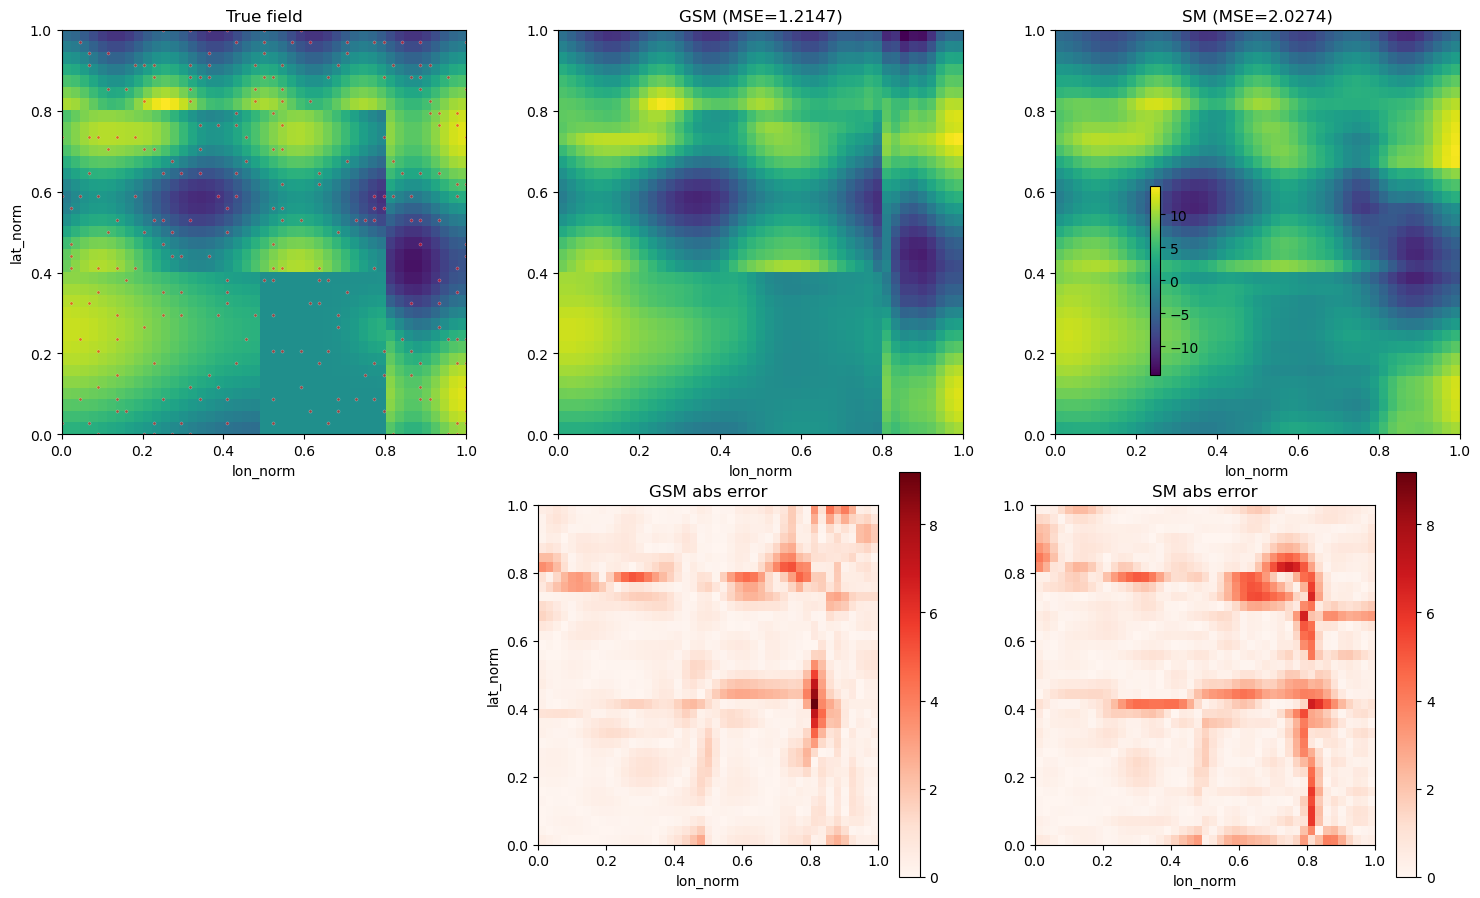


EXPERIMENT COMPLETE


In [13]:
# ===============================================================
# 9. RUN EVERYTHING
# ===============================================================

if __name__ == "__main__":
    (
        lat_norm,
        lon_norm,
        f_clean_grid,
        X_full,
        f_full,
        X_train_np,
        y_train_np,
        X_train,
        y_train,
    ) = generate_geospatial_data(
        n_lat=35, n_lon=45, n_train=250, seed=0
    )

    gsm_model, gsm_lik = train_gsm_2d(
        X_train, y_train,
        Q=5,
        num_iters=500,
    )

    sm_model, sm_lik = train_sm_2d(
        X_train, y_train,
        Q=5,
        num_iters=400,
    )

    plot_comparison_2d(
        lat_norm,
        lon_norm,
        f_clean_grid,
        X_full,
        X_train_np,
        y_train_np,
        gsm_model,
        gsm_lik,
        sm_model,
        sm_lik,
    )

    print("\nEXPERIMENT COMPLETE")

In [14]:
def plot_comparison_2d(
    lat_norm,
    lon_norm,
    f_clean_grid,
    X_full,
    X_train_np,
    y_train_np,
    gsm_model,
    gsm_lik,
    sm_model,
    sm_lik,
):
    n_lat, n_lon = f_clean_grid.shape

    Z_true = f_clean_grid

    print("\nGenerating GSM predictions on grid...")
    Z_gsm = predict_on_grid_2d(gsm_model, gsm_lik, X_full, n_lat, n_lon)
    print("Generating SM predictions on grid...")
    Z_sm = predict_on_grid_2d(sm_model, sm_lik, X_full, n_lat, n_lon)

    mse_gsm = np.mean((Z_gsm - Z_true) ** 2)
    mse_sm = np.mean((Z_sm - Z_true) ** 2)

    print("\n" + "="*60)
    print("MSE vs TRUE FIELD (2D)")
    print(f"  GSM: {mse_gsm:.6f}")
    print(f"  SM : {mse_sm:.6f}")
    if mse_gsm < mse_sm:
        print(f"  🎉 GSM wins by {mse_sm / mse_gsm:.2f}×")
    else:
        print(f"  SM wins by {mse_gsm / mse_sm:.2f}×")
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    vmin = min(Z_true.min(), Z_gsm.min(), Z_sm.min())
    vmax = max(Z_true.max(), Z_gsm.max(), Z_sm.max())

    im0 = axes[0, 0].imshow(
        Z_true,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
    )
    axes[0, 0].scatter(
        X_train_np[:, 1],
        X_train_np[:, 0],
        c="red",
        s=5,
        alpha=0.5,
        edgecolor="white",
        linewidth=0.3,
    )
    axes[0, 0].set_title("True field")
    axes[0, 0].set_xlabel("lon_norm")
    axes[0, 0].set_ylabel("lat_norm")

    im1 = axes[0, 1].imshow(
        Z_gsm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
    )
    axes[0, 1].set_title(f"GSM (MSE={mse_gsm:.4f})")
    axes[0, 1].set_xlabel("lon_norm")

    im2 = axes[0, 2].imshow(
        Z_sm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
    )
    axes[0, 2].set_title(f"SM (MSE={mse_sm:.4f})")
    axes[0, 2].set_xlabel("lon_norm")

    err_gsm = np.abs(Z_gsm - Z_true)
    err_sm = np.abs(Z_sm - Z_true)
    emax = max(err_gsm.max(), err_sm.max())

    axes[1, 0].axis("off")

    im3 = axes[1, 1].imshow(
        err_gsm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=0,
        vmax=emax,
        cmap="Reds",
    )
    axes[1, 1].set_title("GSM abs error")
    axes[1, 1].set_xlabel("lon_norm")
    axes[1, 1].set_ylabel("lat_norm")
    plt.colorbar(im3, ax=axes[1, 1])

    im4 = axes[1, 2].imshow(
        err_sm,
        extent=[0, 1, 0, 1],
        origin="lower",
        vmin=0,
        vmax=emax,
        cmap="Reds",
    )
    axes[1, 2].set_title("SM abs error")
    axes[1, 2].set_xlabel("lon_norm")
    plt.colorbar(im4, ax=axes[1, 2])

    plt.colorbar(im0, ax=axes[0, :], location="right", shrink=0.6)
    plt.tight_layout()
    plt.show()


Generating GSM predictions on grid...
Generating SM predictions on grid...

MSE vs TRUE FIELD (2D)
  GSM: 1.214733
  SM : 2.027363
  🎉 GSM wins by 1.67×


/tmp/ipykernel_633525/15093507.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


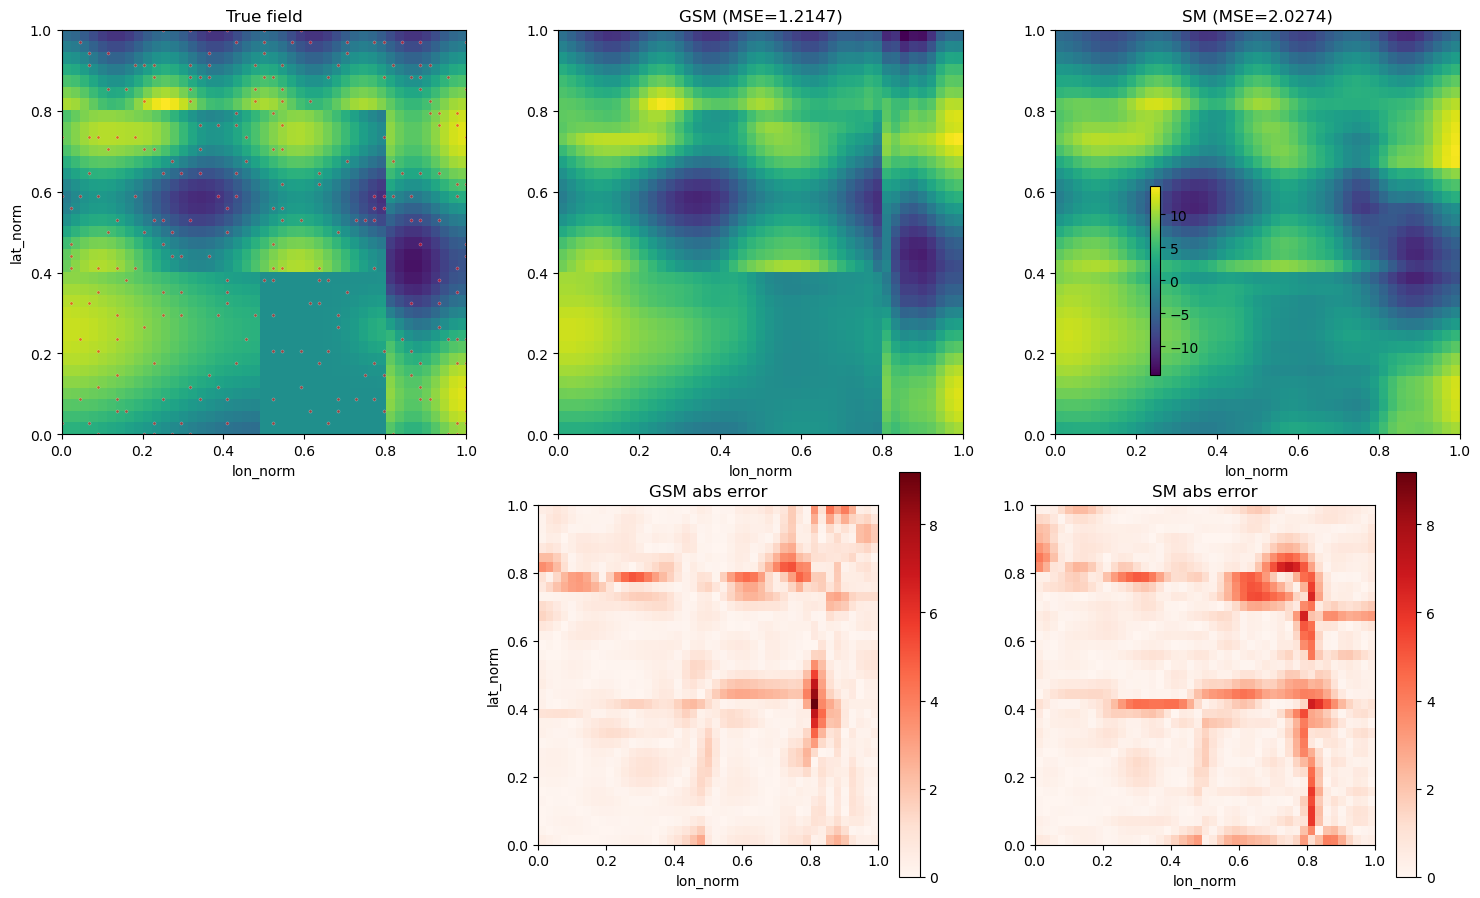

In [15]:
    plot_comparison_2d(
        lat_norm,
        lon_norm,
        f_clean_grid,
        X_full,
        X_train_np,
        y_train_np,
        gsm_model,
        gsm_lik,
        sm_model,
        sm_lik,
    )